# Programs

Esta tabla contiene la información a nivel de programa.

## 1 - Obtencion de datos

In [6]:
import matplotlib.pyplot as plt
import importlib
from notebooks_utils import *

full_table = get_data('programs')

# Table name, features and target.
TABLE_NAME = 'programs'
TABLE_FEATURES = ['program__has_sub_dirs_with_code','program__has_packages','program__number_of_modules','program__number_of_sub_dirs_with_code','program__number_of_packages','program__class_defs_pct','program__function_defs_pct','program__enum_defs_pct','program__has_code_root_package','program__average_defs_per_module','program__expertise_level']
TABLE_TARGET = 'program__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. Each of the instances corresponds to a program. For each program we have {X.shape[1]} attributes.')

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

In [4]:
importlib.reload(print_histogram)

NameError: name 'print_histogram' is not defined

## 2 - Exploracion de datos

In [58]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   program__has_sub_dirs_with_code        1609 non-null   bool   
 1   program__has_packages                  1609 non-null   bool   
 2   program__number_of_modules             1609 non-null   int64  
 3   program__number_of_sub_dirs_with_code  1609 non-null   int64  
 4   program__number_of_packages            1609 non-null   int64  
 5   program__class_defs_pct                1609 non-null   float64
 6   program__function_defs_pct             1609 non-null   float64
 7   program__enum_defs_pct                 1609 non-null   float64
 8   program__has_code_root_package         1609 non-null   bool   
 9   program__average_defs_per_module       1609 non-null   float64
 10  program__expertise_level               1609 non-null   object 
dtypes: b

Cómo podemos ver la tabla está compuesta por ocho variables numéricas, tres variables boleanas y una de tipo objeto. La variable de tipo objeto es la variable objetivo, que contiene la información sobre el nivel de experiencia del programador.

### 2.1 - Equilibrado de clases

In [59]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 98.88% instances for BEGINNER class and 1.119% for EXPERT class.


### 2.2 - Valores Nulos
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [60]:
X.isnull().sum()

program__has_sub_dirs_with_code          0
program__has_packages                    0
program__number_of_modules               0
program__number_of_sub_dirs_with_code    0
program__number_of_packages              0
program__class_defs_pct                  0
program__function_defs_pct               0
program__enum_defs_pct                   0
program__has_code_root_package           0
program__average_defs_per_module         0
program__expertise_level                 0
dtype: int64

Aunque una columna no contenga valores nulos podría ser que contenga valores vacíos.

In [61]:
print_empty_cols(X)

program__has_sub_dirs_with_code
-------------------------------
0 instancias no tienen un valor para la columna program__has_sub_dirs_with_code


program__has_packages
---------------------
0 instancias no tienen un valor para la columna program__has_packages


program__number_of_modules
--------------------------
0 instancias no tienen un valor para la columna program__number_of_modules


program__number_of_sub_dirs_with_code
-------------------------------------
0 instancias no tienen un valor para la columna program__number_of_sub_dirs_with_code


program__number_of_packages
---------------------------
0 instancias no tienen un valor para la columna program__number_of_packages


program__class_defs_pct
-----------------------
0 instancias no tienen un valor para la columna program__class_defs_pct


program__function_defs_pct
--------------------------
0 instancias no tienen un valor para la columna program__function_defs_pct


program__enum_defs_pct
----------------------
0 instanci

### 2.3 - Describimos los valores de las variables de la tabla.

In [62]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
program__has_sub_dirs_with_code,1609,2,False,1558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
program__has_packages,1609,2,False,1586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
program__number_of_modules,1609.0,NaN,NaN,NaN,11.327533,125.3427,1.0,1.0,3.0,3.0,3294.0
program__number_of_sub_dirs_with_code,1609.0,NaN,NaN,NaN,0.394655,6.890508,0.0,0.0,0.0,0.0,238.0
program__number_of_packages,1609.0,NaN,NaN,NaN,1.646986,34.325279,0.0,0.0,0.0,0.0,1297.0
program__class_defs_pct,1609.0,NaN,NaN,NaN,0.011369,0.078807,0.0,0.0,0.0,0.0,1.0
program__function_defs_pct,1609.0,NaN,NaN,NaN,0.650481,0.47164,0.0,0.0,1.0,1.0,1.0
program__enum_defs_pct,1609.0,NaN,NaN,NaN,0.000052,0.000781,0.0,0.0,0.0,0.0,0.019078
program__has_code_root_package,1609,2,True,1604,NaN,NaN,NaN,NaN,NaN,NaN,NaN
program__average_defs_per_module,1609.0,NaN,NaN,NaN,1.80408,2.950492,0.0,0.0,0.666667,2.142857,26.0


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [63]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "program__class_defs_pct": [(0.0, 0.0), (0.0, inf)],  # min: 0.0 max: 1.0
    "program__function_defs_pct": [(0.0, 0.0),(0.0, 1.0), (1.0, 1.0)],  # min: 0.0 max: 1.0
    "program__enum_defs_pct": [(0.0, 0.0), (0.0, inf)],  # min: 0.0 max: 0.19
    "program__number_of_modules": [(1, 1), (2,2), (3,3), (4,inf)],  # min: 1 max: 3294
    "program__number_of_sub_dirs_with_code": [(0, 0), (0, inf)], # min: 0 max: 238
    "program__number_of_packages": [(0, 0), (0, inf)], # min: 0 max: 1297
    "program__average_defs_per_module": [(0, 0), (0, 1), (1, 3), (3, inf)], # min: 0 max: 26    
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['program__has_sub_dirs_with_code'], 10))
print(get_statistics(X_copy, ['program__has_packages'], 10))
print(get_statistics(X_copy, ['program__has_code_root_package'], 10))
print(get_statistics(X_copy, ['program__class_defs_pct'], 10))
print(get_statistics(X_copy, ['program__function_defs_pct'], 10))
print(get_statistics(X_copy, ['program__enum_defs_pct'], 10))
print(get_statistics(X_copy, ['program__number_of_sub_dirs_with_code'], 10))
print(get_statistics(X_copy, ['program__number_of_modules'], 10))
print(get_statistics(X_copy, ['program__number_of_packages'], 10))
print(get_statistics(X_copy, ['program__average_defs_per_module'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
print(get_statistics(X_copy, ['program__has_sub_dirs_with_code', 'program__has_packages'], 10))
print(get_statistics(X_copy, ['program__has_sub_dirs_with_code', 'program__has_code_root_package'], 10))
print(get_statistics(X_copy, ['program__has_packages', 'program__has_code_root_package'], 10))
print(get_statistics(X_copy, ['program__class_defs_pct', 'program__function_defs_pct'], 10))
print(get_statistics(X_copy, ['program__class_defs_pct', 'program__enum_defs_pct'], 10))
print(get_statistics(X_copy, ['program__function_defs_pct', 'program__enum_defs_pct'], 10))
print(get_statistics(X_copy, ['program__number_of_sub_dirs_with_code', 'program__number_of_modules'], 10))
print(get_statistics(X_copy, ['program__number_of_sub_dirs_with_code', 'program__number_of_packages'], 10))
print(get_statistics(X_copy, ['program__number_of_modules', 'program__number_of_packages'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
print(get_statistics(X_copy, ['program__has_sub_dirs_with_code', 'program__has_packages', 'program__has_code_root_package'], 10))
print(get_statistics(X_copy, ['program__class_defs_pct', 'program__function_defs_pct', 'program__enum_defs_pct'], 10))
print(get_statistics(X_copy, ['program__number_of_sub_dirs_with_code', 'program__number_of_modules', 'program__number_of_packages'], 10))

--- SINGLE FEATURE ---
 program__has_sub_dirs_with_code  count  percentage
                           False   1558   96.830329
                            True     51    3.169671

 program__has_packages  count  percentage
                 False   1586   98.570541
                  True     23    1.429459

 program__has_code_root_package  count  percentage
                           True   1604   99.689248
                          False      5    0.310752

program__class_defs_pct  count  percentage
              [0.0_0.0]   1560    96.95463
              [0.0_inf]     49     3.04537

program__function_defs_pct  count  percentage
                 [1.0_1.0]   1016   63.144810
                 [0.0_0.0]    547   33.996271
                 [0.0_1.0)     46    2.858919

program__enum_defs_pct  count  percentage
             [0.0_0.0]   1597   99.254195
             [0.0_inf]     12    0.745805

program__number_of_sub_dirs_with_code  count  percentage
                                [0_0]   

IMPORTANTE: Hay 544 programas sin clases, funciones ni enums -> la asignatura de FI se divide en tres partes, sintaxis, sentencias de control y finalmente funciones. Es decir durante dos terceras partes no saben lo que son funciones. Ademas apenas usan clases en todo el curso.

In [64]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (1609, 12)
Target shape: (1609,)


#### Muestra la matriz de correlación de Spearman entre las variables de la tabla.

<Axes: >

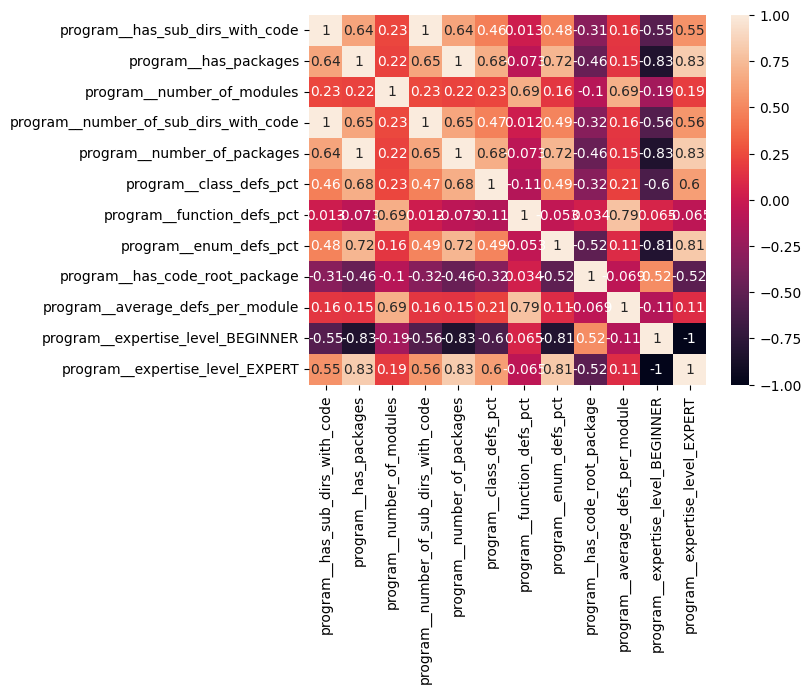

In [65]:
sns.heatmap(X.corr(method='spearman'), annot=True)

### IMPORTANTE
De la matriz anterior ya podemos sacar alguna conclusión que puede parecer obvia. Por ejemplo, la presencia de paquetes esta fuertemente relacionada con la experiencia del programador.

## 3 - Detección de valores atípicos (outliers)
## Univariate
## Analisis detallado de variables
Para cada una de las 10 variable (3 booleanas, 4 porcentuales y 3 numericas) se hara un analisis detallado

### Variable has_sub_dirs_with_code (1/10)
Esta variable es de tipo booleano y representa si el programa contiene algún subdirectorio con código.

<Axes: xlabel='program__has_sub_dirs_with_code', ylabel='Count'>

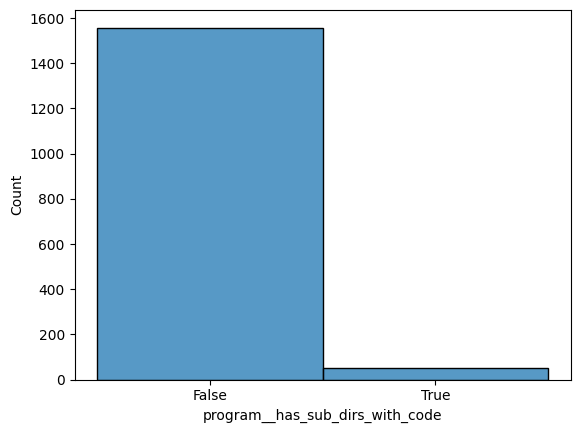

In [66]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['program__has_sub_dirs_with_code'], discrete=True)

In [67]:
num_true_values = len(X[X['program__has_sub_dirs_with_code'] == True])
num_false_values = len(X[X['program__has_sub_dirs_with_code'] == False])
std = X['program__has_sub_dirs_with_code'].std()
freq_true = len(X[X['program__has_sub_dirs_with_code'] == True]) / len(X['program__has_sub_dirs_with_code'])
freq_false = len(X[X['program__has_sub_dirs_with_code'] == False]) / len(X['program__has_sub_dirs_with_code'])
print(f'La variable has_sub_dirs_with_code contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_sub_dirs_with_code a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_sub_dirs_with_code a False es {freq_false}.')

La variable has_sub_dirs_with_code contiene 51 valores verdaderos y 1558 valores falsos. Y, la desviación típica es de 0.17524586617946625
La frecuencia con la que programa puede tener la variable has_sub_dirs_with_code a True es 0.031696706028589185.
La frecuencia con la que programa puede tener la variable has_sub_dirs_with_code a False es 0.9683032939714108.


In [68]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'program__has_sub_dirs_with_code', possible_values)

La variable program__has_sub_dirs_with_code contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable program__has_sub_dirs_with_code toma el valor de 0.0 en un 96.83% de los items.
La variable program__has_sub_dirs_with_code toma el valor de 1.0 en un 3.17% de los items.


Describimos los valores de las variables de la tabla, cuando la variable tiene el valor a True.

In [69]:
X[X['program__has_sub_dirs_with_code'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,51.0,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1.0,0.431373,282.568634,12.450980,51.764706,0.164255,0.814500,0.001638,0.901961,4.124859,0.666667,0.333333
std,0.0,0.500196,653.941162,37.064976,187.733383,0.195925,0.227913,0.004116,0.300327,3.806759,0.476095,0.476095
min,1.0,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,3.000000,1.000000,0.000000,0.000000,0.633807,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.0,0.000000,7.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.155406,1.000000,0.000000
75%,1.0,1.000000,392.500000,4.000000,45.000000,0.365667,1.000000,0.000000,1.000000,5.775416,1.000000,1.000000
max,1.0,1.000000,3294.000000,238.000000,1297.000000,0.624539,1.000000,0.019078,1.000000,17.000000,1.000000,1.000000


### Variable has_packages (2/10)
Esta variable es de tipo booleano y representa si el programa contiene algún paquete.

<Axes: xlabel='program__has_packages', ylabel='Count'>

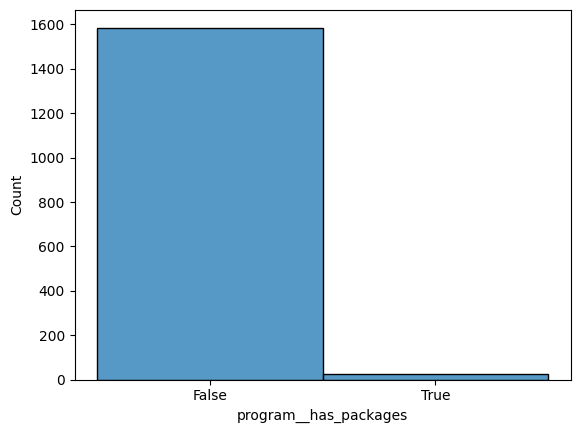

In [70]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['program__has_packages'], discrete=True)

In [71]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['program__has_packages'] == True])
num_false_values = len(X[X['program__has_packages'] == False])
std = X['program__has_packages'].std()
freq_true = len(X[X['program__has_packages'] == True]) / len(X['program__has_packages'])
freq_false = len(X[X['program__has_packages'] == False]) / len(X['program__has_packages'])
print(f'La variable program__has_packages contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable program__has_packages a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable program__has_packages a False es {freq_false}.')

La variable program__has_packages contiene 23 valores verdaderos y 1586 valores falsos. Y, la desviación típica es de 0.1187392994761467
La frecuencia con la que programa puede tener la variable program__has_packages a True es 0.014294592914853946.
La frecuencia con la que programa puede tener la variable program__has_packages a False es 0.9857054070851461.


In [72]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'program__has_packages', possible_values)

La variable program__has_packages contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable program__has_packages toma el valor de 0.0 en un 98.57% de los items.
La variable program__has_packages toma el valor de 1.0 en un 1.429% de los items.


Describimos los valores de las variables de la tabla, cuando la variable tiene el valor a True.

In [73]:
X[X['program__has_packages'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.956522,1.0,622.304321,25.826086,115.217392,0.351689,0.644680,0.003632,0.782609,4.401488,0.260870,0.739130
std,0.208514,0.0,867.284790,52.718510,269.142059,0.112088,0.111641,0.005562,0.421741,2.107967,0.448978,0.448978
min,0.000000,1.0,32.000000,0.000000,2.000000,0.162427,0.375461,0.000000,0.000000,0.785714,0.000000,0.000000
25%,1.000000,1.0,141.500000,3.000000,10.500000,0.289631,0.608187,0.000000,1.000000,2.904226,0.000000,0.500000
50%,1.000000,1.0,468.000000,4.000000,67.000000,0.366720,0.633280,0.000391,1.000000,4.531250,0.000000,1.000000
75%,1.000000,1.0,544.000000,18.500000,73.000000,0.385097,0.706506,0.005803,1.000000,5.761029,0.500000,1.000000
max,1.000000,1.0,3294.000000,238.000000,1297.000000,0.624539,0.836595,0.019078,1.000000,9.957198,1.000000,1.000000


### Variable has_code_root_packages (3/10)
Esta variable es de tipo booleano y representa si el programa contiene código en el directorio root.

<Axes: xlabel='program__has_code_root_package', ylabel='Count'>

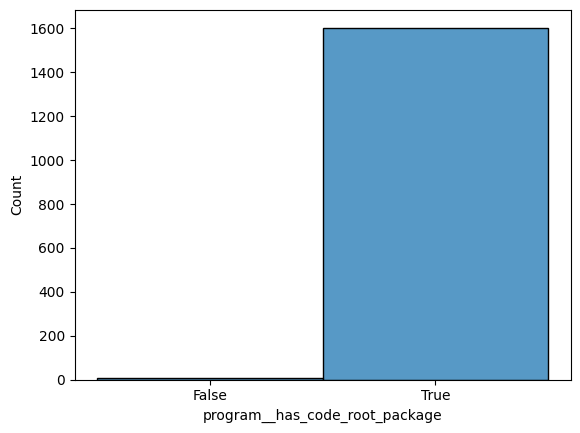

In [74]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['program__has_code_root_package'], discrete=True)

In [75]:
#ANALISIS DE DISTRIBUCIÓN DE DATOS
num_true_values = len(X[X['program__has_code_root_package'] == True])
num_false_values = len(X[X['program__has_code_root_package'] == False])
std = X['program__has_code_root_package'].std()
freq_true = len(X[X['program__has_code_root_package'] == True]) / len(X['program__has_code_root_package'])
freq_false = len(X[X['program__has_code_root_package'] == False]) / len(X['program__has_code_root_package'])
print(f'La variable program__has_code_root_package contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable program__has_code_root_package a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable program__has_code_root_package a False es {freq_false}.')

La variable program__has_code_root_package contiene 1604 valores verdaderos y 5 valores falsos. Y, la desviación típica es de 0.05567575991153717
La frecuencia con la que programa puede tener la variable program__has_code_root_package a True es 0.9968924798011187.
La frecuencia con la que programa puede tener la variable program__has_code_root_package a False es 0.003107520198881293.


In [76]:
#PROBABILIDAD DE VALORES
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'program__has_code_root_package', possible_values)

La variable program__has_code_root_package contiene 2 valores distintos.
El umbral de outlier es de 0.1%
La variable program__has_code_root_package toma el valor de 1.0 en un 99.69% de los items.
La variable program__has_code_root_package toma el valor de 0.0 en un 0.3108% de los items.


Describimos los valores de las variables de la tabla, cuando la variable tiene el valor a False.

In [77]:
X[X['program__has_code_root_package'] == False].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.0
mean,1.0,1.0,1550.000000,68.199997,354.799988,0.372176,0.620500,0.007324,0.0,3.922878,0.0,1.0
std,0.0,0.0,1596.469238,98.082619,548.381897,0.147461,0.145035,0.007107,0.0,1.456639,0.0,0.0
min,1.0,1.0,118.000000,8.000000,5.000000,0.248424,0.375461,0.000000,0.0,1.829994,0.0,1.0
25%,1.0,1.0,396.000000,9.000000,38.000000,0.302200,0.611977,0.004658,0.0,3.079819,0.0,1.0
50%,1.0,1.0,664.000000,18.000000,52.000000,0.316770,0.678571,0.005551,0.0,4.451495,0.0,1.0
75%,1.0,1.0,3278.000000,68.000000,382.000000,0.368945,0.690465,0.007335,0.0,4.795455,0.0,1.0
max,1.0,1.0,3294.000000,238.000000,1297.000000,0.624539,0.746025,0.019078,0.0,5.457627,0.0,1.0


### Variable number_of_modules (4/10)
Esta variable es de tipo numérica y nos indica el número de modulos definidos en el programa. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 3294. Con una media de 11,3.

<Axes: ylabel='program__number_of_modules'>

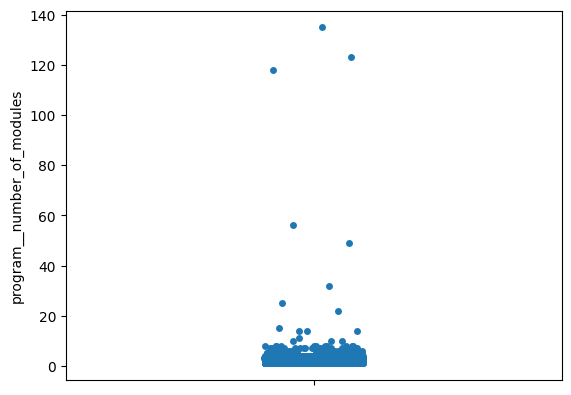

In [78]:
sns.stripplot(X[X['program__number_of_modules'] < 143]['program__number_of_modules'])

### IMPORTANTE
Los dos valores máximos están muy alejados del siguiente.

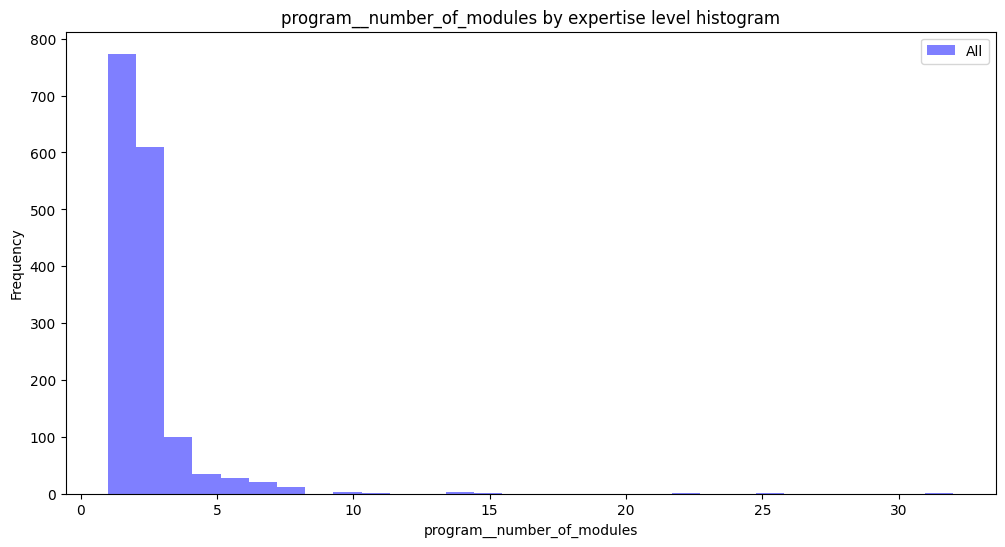

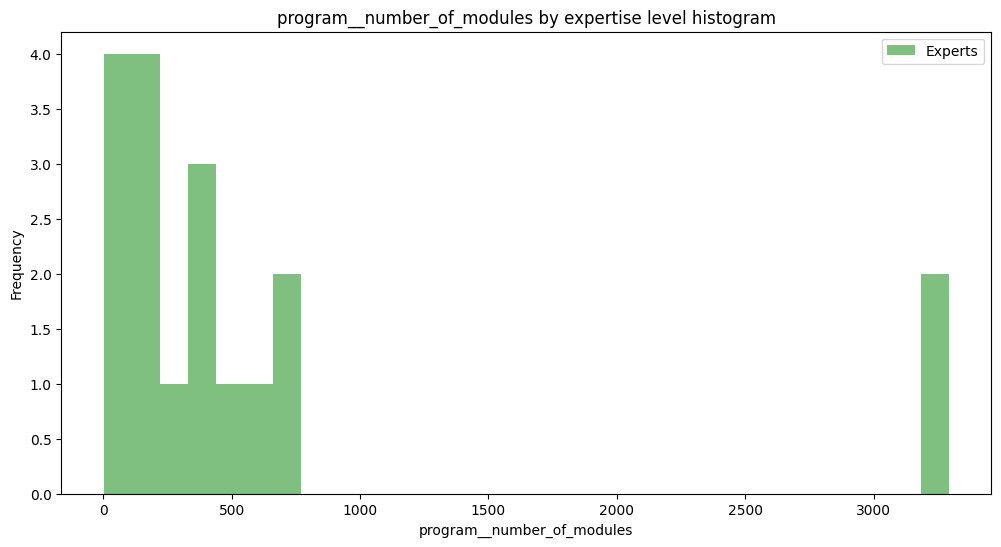

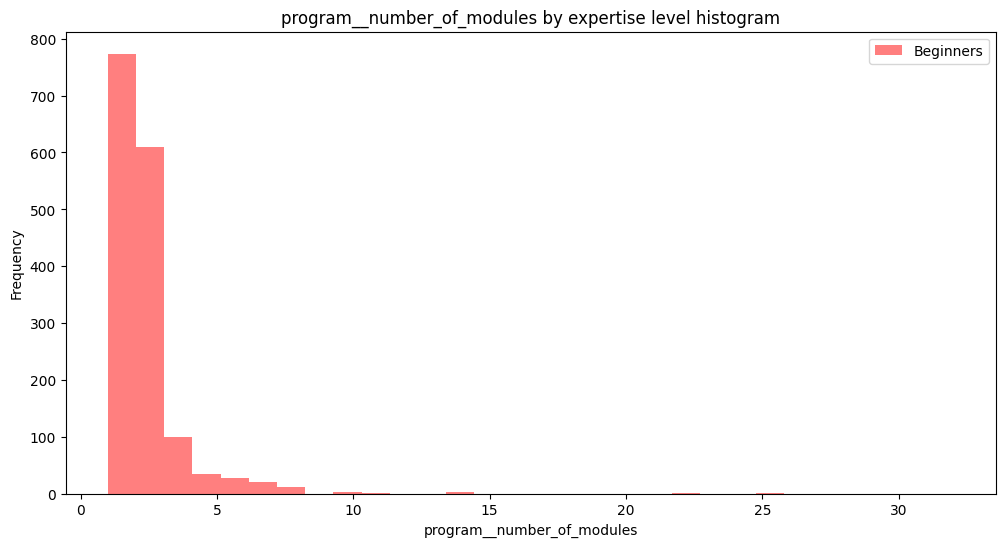

In [79]:
print_histogram(X, 'program__number_of_modules', 'program__expertise_level', include_all=True, include_beginners=False, include_experts=False, max_value=40)
print_histogram(X, 'program__number_of_modules', 'program__expertise_level', include_all=False, include_beginners=False, include_experts=True)
print_histogram(X, 'program__number_of_modules', 'program__expertise_level', include_all=False, include_beginners=True, include_experts=False, max_value=40)

Se establece un valor máximo de 40 para poder apreciar la distribución de los valores bajos.

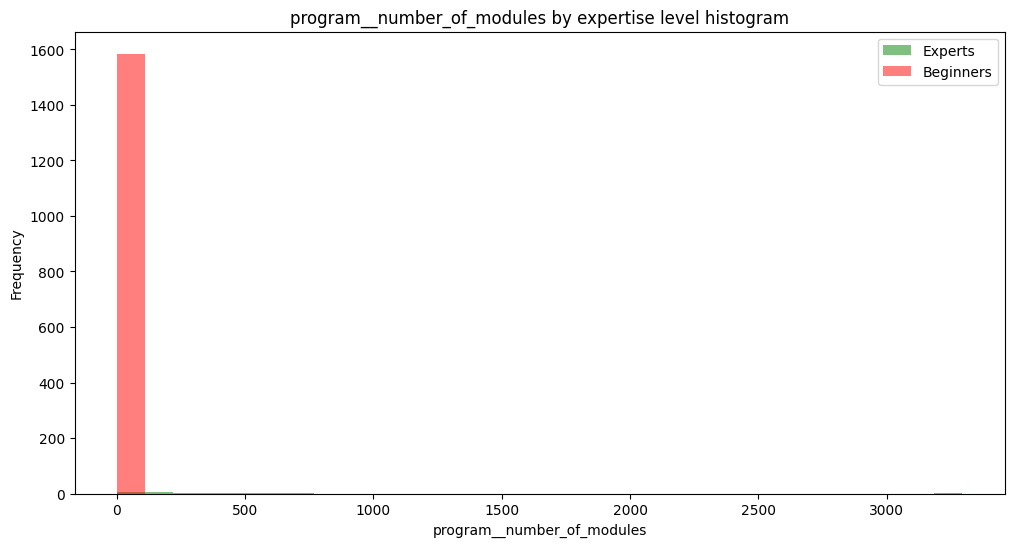

In [80]:
Y = X[~((X['program__expertise_level_BEGINNER'] == 1) & (X['program__number_of_modules'] > 143))]
print_histogram(Y, 'program__number_of_modules', 'program__expertise_level', include_all=False, include_beginners=True, include_experts=True)

En estos gráficos, se incluyen los valores outliers. 

In [81]:
print_outliers_for_df_column(X, 'program__number_of_modules')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9621331816503333
Rango valores atípicos extremos (Tukey): [-5.0,9.0]
Rango valores atípicos leves (Tukey): [-2.0,6.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.8965693404781191,143.77248636216797]
-3.0IQR: 0 instancias tienen un valor para program__number_of_modules inferior a -5.0 (Q1-3*IQR) para program__number_of_modules. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para program__number_of_modules inferior a -2.0 (Q1-1.5*IQR) para program__number_of_modules. Representando un 0.0% del total de instancias.
+1.5IQR: 64 instancias tienen un valor para program__number_of_modules superior a 6.0 (Q3+1.5*IQR) para program__number_of_modules. Representando un 3.978% del total de instancias.
+3.0IQR: 33 instancias tienen un valor para program__number_of_modules superior a 9.0 (Q3-3*IQR) para program__number_of_modules. Representando un 2.051% del total de instancias.
L: 0 instancias t

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 143 (Con un MC de 96 usamos U)

In [82]:
X[X['program__number_of_modules'] > 143.7].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,17.0,17.0,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,1.0,1.0,811.764709,32.705883,153.235291,0.365652,0.631066,0.003282,0.764706,4.438142,0.352941,0.647059
std,0.0,0.0,942.034851,60.113190,306.116089,0.096148,0.095510,0.005320,0.437237,2.047177,0.492592,0.492592
min,1.0,1.0,148.000000,1.000000,9.000000,0.162427,0.375461,0.000000,0.000000,1.709030,0.000000,0.000000
25%,1.0,1.0,396.000000,3.000000,52.000000,0.344754,0.604396,0.000000,1.000000,3.079819,0.000000,0.000000
50%,1.0,1.0,541.000000,4.000000,73.000000,0.366837,0.633163,0.000391,1.000000,4.451495,0.000000,1.000000
75%,1.0,1.0,598.000000,46.000000,75.000000,0.395604,0.644540,0.005551,1.000000,5.761029,1.000000,1.000000
max,1.0,1.0,3294.000000,238.000000,1297.000000,0.624539,0.836595,0.019078,1.000000,9.957198,1.000000,1.000000


### Variable number_of_sub_dirs_with_code (5/10)
Esta variable representa el número de subdirectorios con ficheros python pero sin un __init__.py en ellos. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 238. Con una media de 0.394034.

<Axes: ylabel='program__number_of_sub_dirs_with_code'>

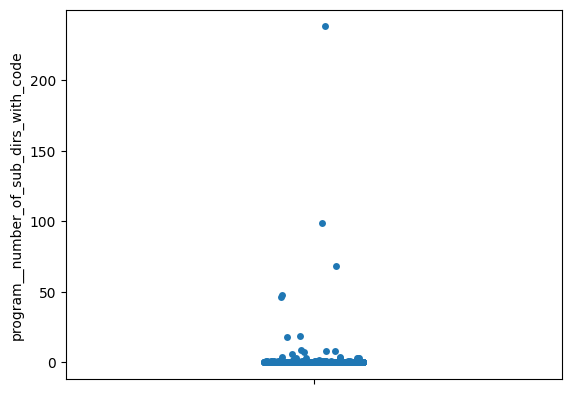

In [83]:
sns.stripplot(X['program__number_of_sub_dirs_with_code'])

### IMPORTANTE
El valor máximo está muy alejado del siguiente. 

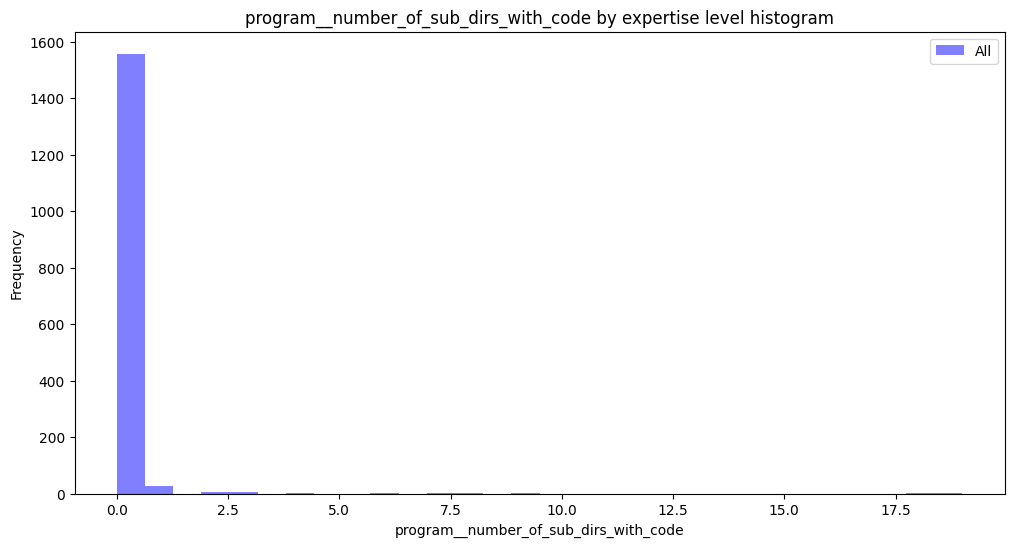

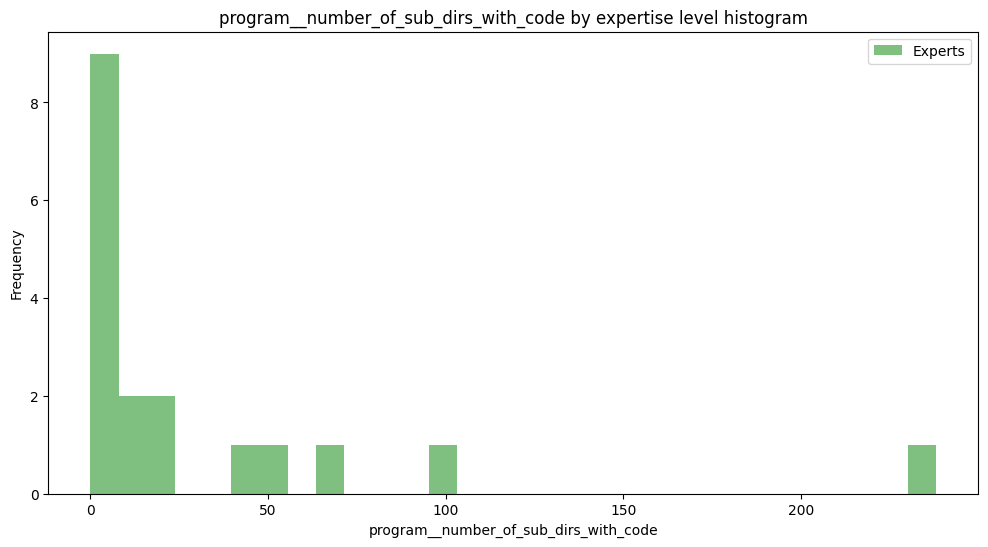

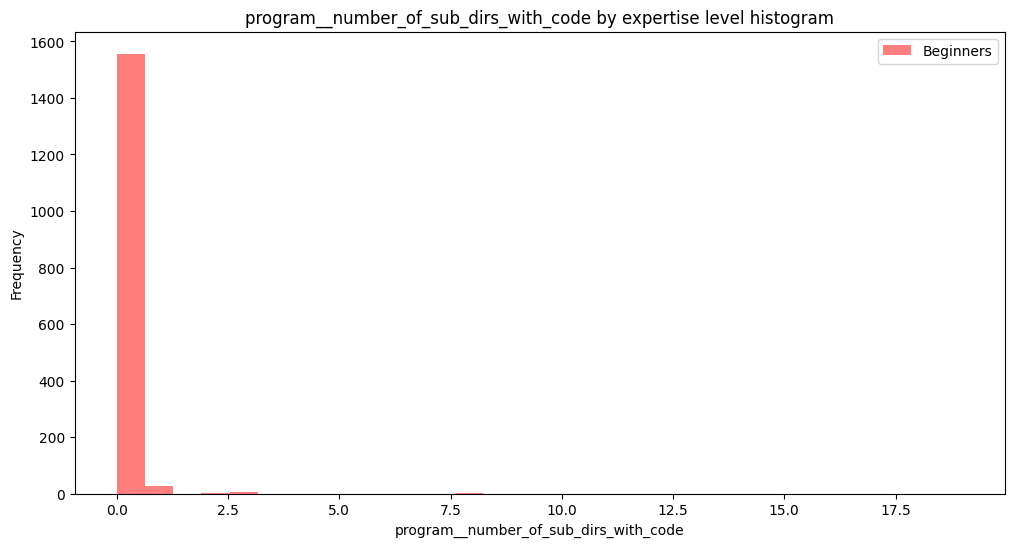

In [84]:
print_histogram(X, 'program__number_of_sub_dirs_with_code', 'program__expertise_level', bins=30, include_all=True, include_beginners=False, include_experts=False, max_value=40)
print_histogram(X, 'program__number_of_sub_dirs_with_code', 'program__expertise_level', bins=30, include_all=False, include_beginners=False)
print_histogram(X, 'program__number_of_sub_dirs_with_code', 'program__expertise_level', bins=30, include_all=False, include_beginners=True, include_experts=False, max_value=40)

In [85]:
print_outliers_for_df_column(X, 'program__number_of_sub_dirs_with_code')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9705333019697744
Rango valores atípicos extremos (Tukey): [0.0,0.0]
Rango valores atípicos leves (Tukey): [0.0,0.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.0,0.0]
-3.0IQR: 0 instancias tienen un valor para program__number_of_sub_dirs_with_code inferior a 0.0 (Q1-3*IQR) para program__number_of_sub_dirs_with_code. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para program__number_of_sub_dirs_with_code inferior a 0.0 (Q1-1.5*IQR) para program__number_of_sub_dirs_with_code. Representando un 0.0% del total de instancias.
+1.5IQR: 51 instancias tienen un valor para program__number_of_sub_dirs_with_code superior a 0.0 (Q3+1.5*IQR) para program__number_of_sub_dirs_with_code. Representando un 3.17% del total de instancias.
+3.0IQR: 51 instancias tienen un valor para program__number_of_sub_dirs_with_code superior a 0.0 (Q3-3*IQR) para program__number_of_sub_dirs_with_code. Representando

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 0 (Todos los umbrales son 0)

In [86]:
X[X['program__number_of_sub_dirs_with_code'] > 0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,51.0,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1.0,0.431373,282.568634,12.450980,51.764706,0.164255,0.814500,0.001638,0.901961,4.124859,0.666667,0.333333
std,0.0,0.500196,653.941162,37.064976,187.733383,0.195925,0.227913,0.004116,0.300327,3.806759,0.476095,0.476095
min,1.0,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,3.000000,1.000000,0.000000,0.000000,0.633807,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.0,0.000000,7.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.155406,1.000000,0.000000
75%,1.0,1.000000,392.500000,4.000000,45.000000,0.365667,1.000000,0.000000,1.000000,5.775416,1.000000,1.000000
max,1.0,1.000000,3294.000000,238.000000,1297.000000,0.624539,1.000000,0.019078,1.000000,17.000000,1.000000,1.000000


### Variable number_of_packages (6/10)
Esta variable representa el número de subdirectorios con ficheros python pero sin un __init__.py en ellos. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 1297. Con una media de 1.642014.

<Axes: ylabel='program__number_of_packages'>

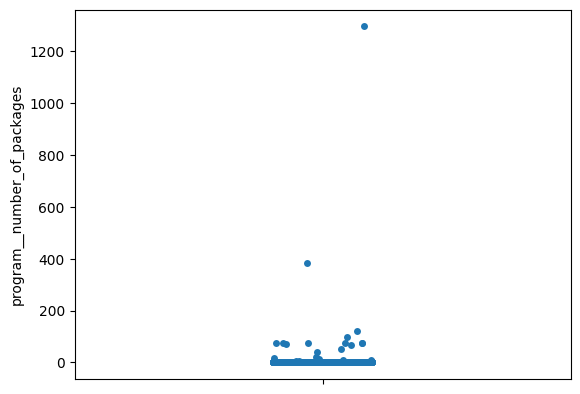

In [87]:
sns.stripplot(X['program__number_of_packages'])

### IMPORTANTE
Los dos valores máximos están muy alejados del siguiente.

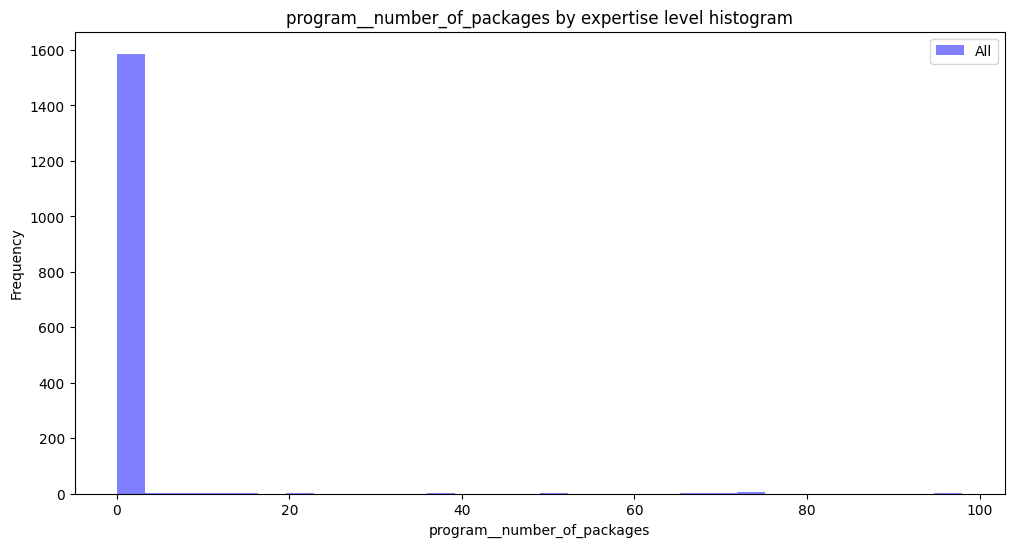

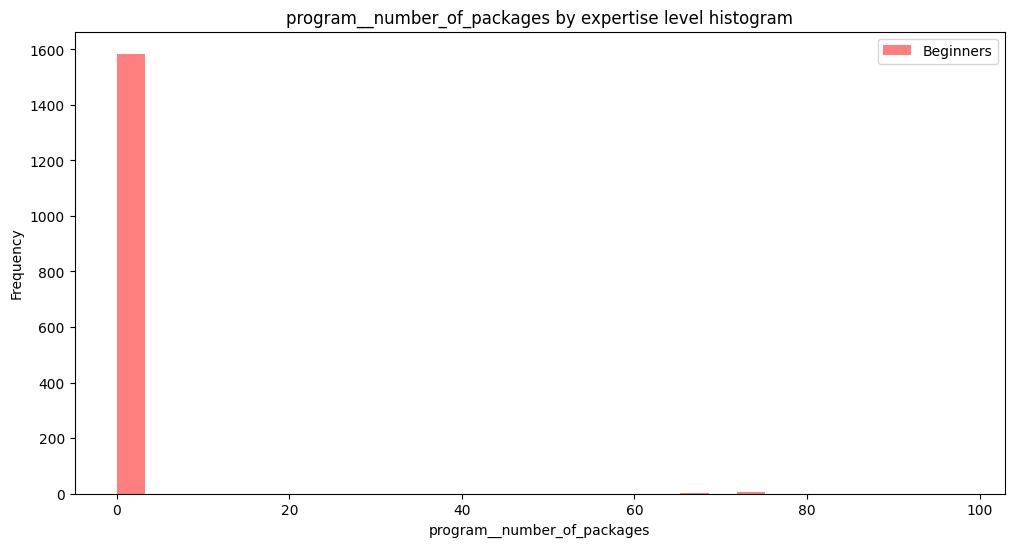

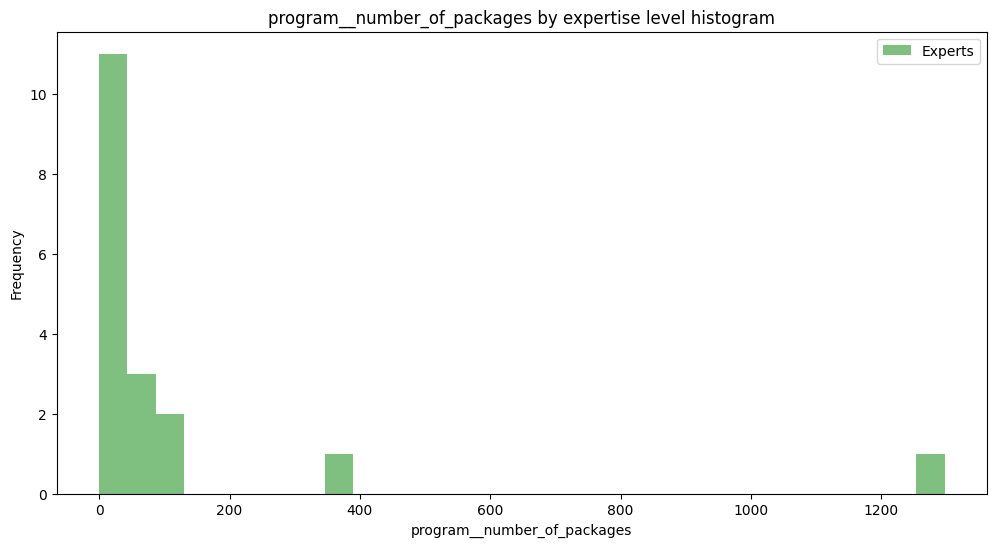

In [88]:
print_histogram(X, 'program__number_of_packages', 'program__expertise_level', bins=30, include_all=True, include_beginners=False, include_experts=False, max_value=100)
print_histogram(X, 'program__number_of_packages', 'program__expertise_level', bins=30, include_all=False, include_beginners=True, include_experts=False, max_value=100)
print_histogram(X, 'program__number_of_packages', 'program__expertise_level', bins=30, include_all=False, include_beginners=False, include_experts=True)

In [89]:
print_outliers_for_df_column(X, 'program__number_of_packages')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9753742229607507
Rango valores atípicos extremos (Tukey): [0.0,0.0]
Rango valores atípicos leves (Tukey): [0.0,0.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.0,0.0]
-3.0IQR: 0 instancias tienen un valor para program__number_of_packages inferior a 0.0 (Q1-3*IQR) para program__number_of_packages. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para program__number_of_packages inferior a 0.0 (Q1-1.5*IQR) para program__number_of_packages. Representando un 0.0% del total de instancias.
+1.5IQR: 23 instancias tienen un valor para program__number_of_packages superior a 0.0 (Q3+1.5*IQR) para program__number_of_packages. Representando un 1.429% del total de instancias.
+3.0IQR: 23 instancias tienen un valor para program__number_of_packages superior a 0.0 (Q3-3*IQR) para program__number_of_packages. Representando un 1.429% del total de instancias.
L: 0 instancias tienen un valor para progra

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 0 (Todos los umbrales son 0)

In [90]:
X[X['program__number_of_packages'] > 0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,0.956522,1.0,622.304321,25.826086,115.217392,0.351689,0.644680,0.003632,0.782609,4.401488,0.260870,0.739130
std,0.208514,0.0,867.284790,52.718510,269.142059,0.112088,0.111641,0.005562,0.421741,2.107967,0.448978,0.448978
min,0.000000,1.0,32.000000,0.000000,2.000000,0.162427,0.375461,0.000000,0.000000,0.785714,0.000000,0.000000
25%,1.000000,1.0,141.500000,3.000000,10.500000,0.289631,0.608187,0.000000,1.000000,2.904226,0.000000,0.500000
50%,1.000000,1.0,468.000000,4.000000,67.000000,0.366720,0.633280,0.000391,1.000000,4.531250,0.000000,1.000000
75%,1.000000,1.0,544.000000,18.500000,73.000000,0.385097,0.706506,0.005803,1.000000,5.761029,0.500000,1.000000
max,1.000000,1.0,3294.000000,238.000000,1297.000000,0.624539,0.836595,0.019078,1.000000,9.957198,1.000000,1.000000


Los casos especiales con number_of_packages > 1000 son los ya mencionados proyectos llama_index y ray.

### Variable average_defs_per_module (7/10)
Esta variable es de tipo numérica y nos indica el número medio de definiciones en un módulo. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 26. Con una media de 1,8.

<Axes: ylabel='program__average_defs_per_module'>

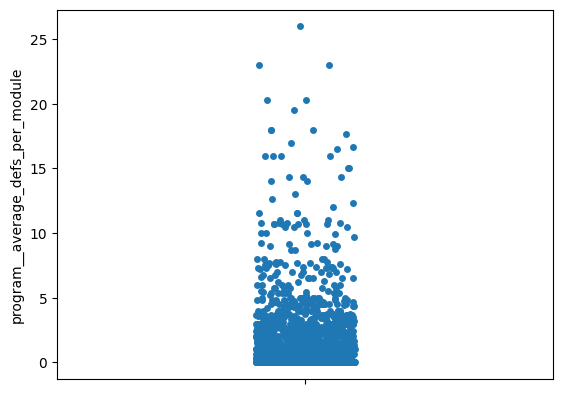

In [91]:
sns.stripplot(X['program__average_defs_per_module'])

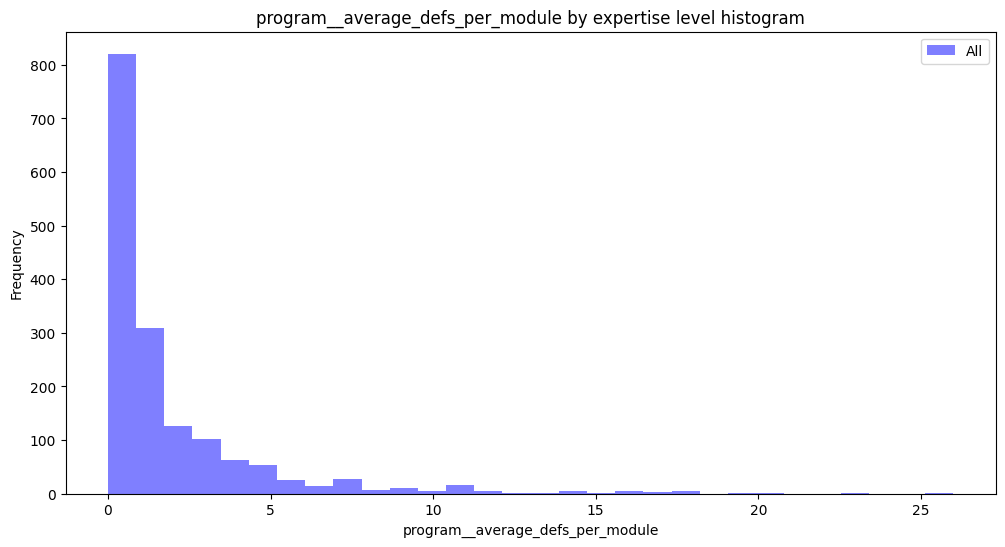

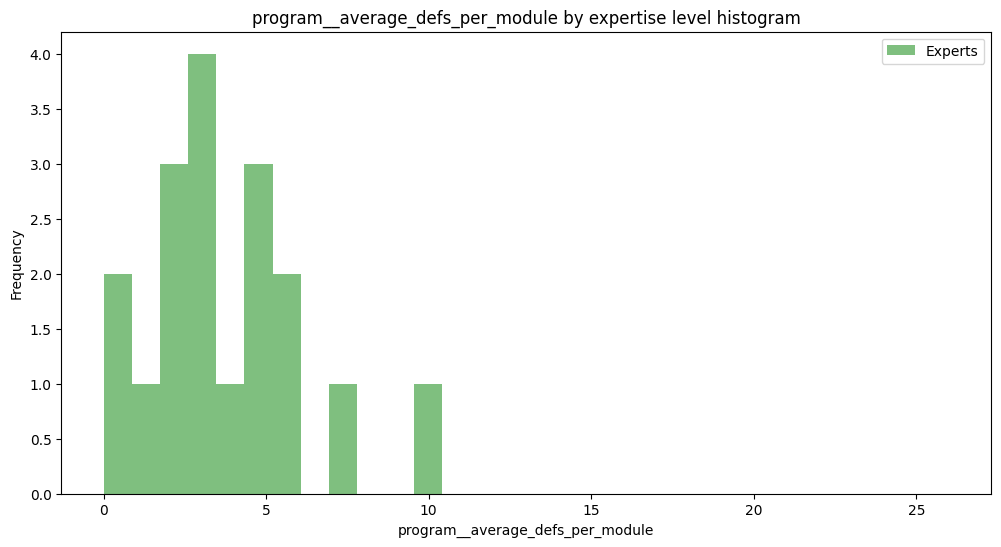

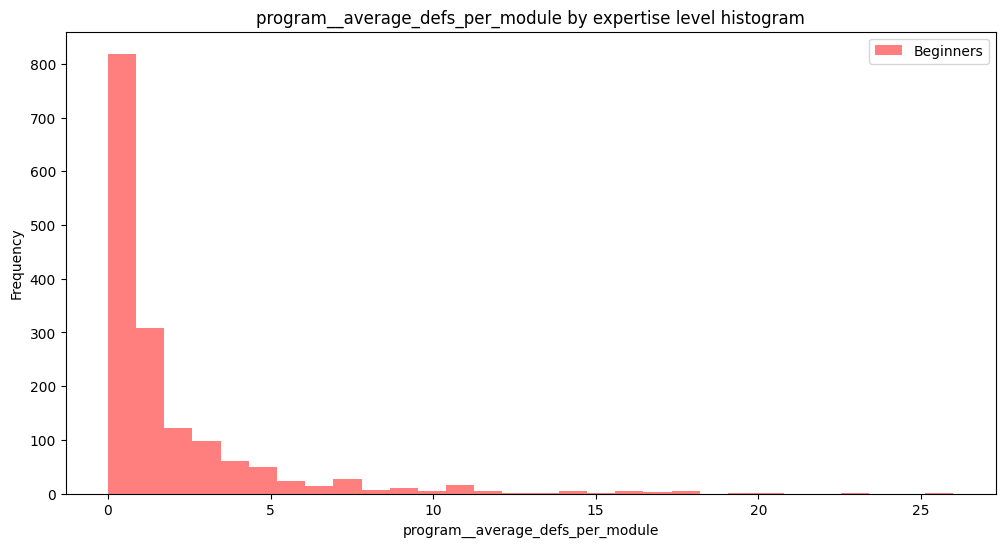

In [92]:
print_histogram(X, 'program__average_defs_per_module', 'program__expertise_level', bins=30, include_all=True, include_experts=False, include_beginners=False)
print_histogram(X, 'program__average_defs_per_module', 'program__expertise_level', bins=30, include_all=False, include_experts=True, include_beginners=False)
print_histogram(X, 'program__average_defs_per_module', 'program__expertise_level', bins=30, include_all=False, include_experts=False, include_beginners=True)

In [93]:
print_outliers_for_df_column(X, 'program__average_defs_per_module')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.7763419665374247
Rango valores atípicos extremos (Tukey): [-6.4285712242126465,8.571428298950195]
Rango valores atípicos leves (Tukey): [-3.2142856121063232,5.357142686843872]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.2123346407932386,73.87744251687852]
-3.0IQR: 0 instancias tienen un valor para program__average_defs_per_module inferior a -6.4285712242126465 (Q1-3*IQR) para program__average_defs_per_module. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para program__average_defs_per_module inferior a -3.2142856121063232 (Q1-1.5*IQR) para program__average_defs_per_module. Representando un 0.0% del total de instancias.
+1.5IQR: 128 instancias tienen un valor para program__average_defs_per_module superior a 5.357142686843872 (Q3+1.5*IQR) para program__average_defs_per_module. Representando un 7.955% del total de instancias.
+3.0IQR: 63 instancias tienen un valor para program__aver

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 8,57 (Con un MC de 77 usamos Tuckey Extremo)

In [94]:
X[X['program__average_defs_per_module'] > 8.57].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.0,63.000000,63.000000,63.000000
mean,0.095238,0.015873,7.761905,0.126984,0.174603,0.019581,0.980413,0.000006,1.0,13.077514,0.984127,0.015873
std,0.295901,0.125988,31.992800,0.457626,1.385870,0.090703,0.090721,0.000049,0.0,4.063147,0.125988,0.125988
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.521739,0.000000,1.0,8.666667,0.000000,0.000000
25%,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,10.250000,1.000000,0.000000
50%,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,11.000000,1.000000,0.000000
75%,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,16.000000,1.000000,0.000000
max,1.000000,1.000000,257.000000,3.000000,11.000000,0.478261,1.000000,0.000391,1.0,26.000000,1.000000,1.000000


### Variable class_defs_pct (8/10)
Esta variable representa el porcentage de las definiciones de un programa que son clases. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 100. Con una media de 1,1%.

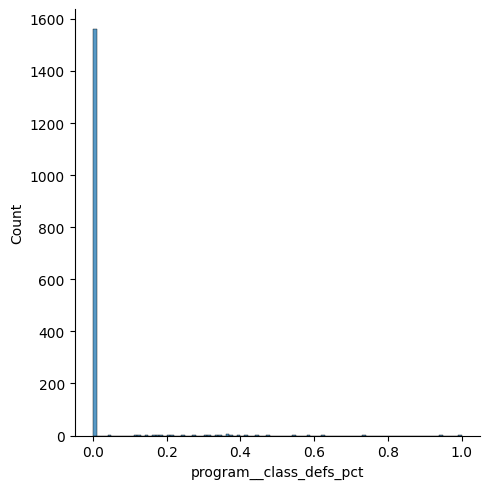

In [95]:
sns.displot(X['program__class_defs_pct'], bins=[i / 100 for i in range(0, 101)])

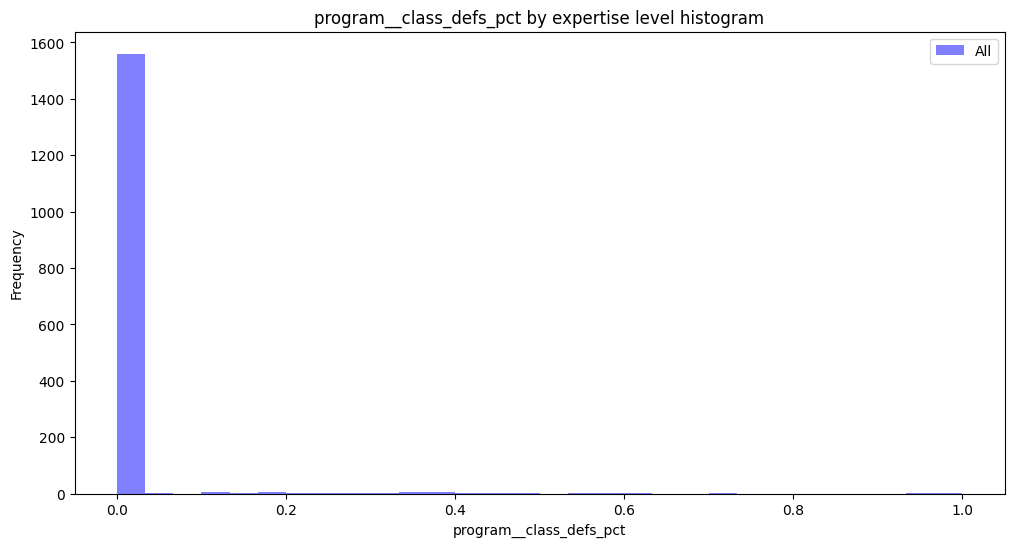

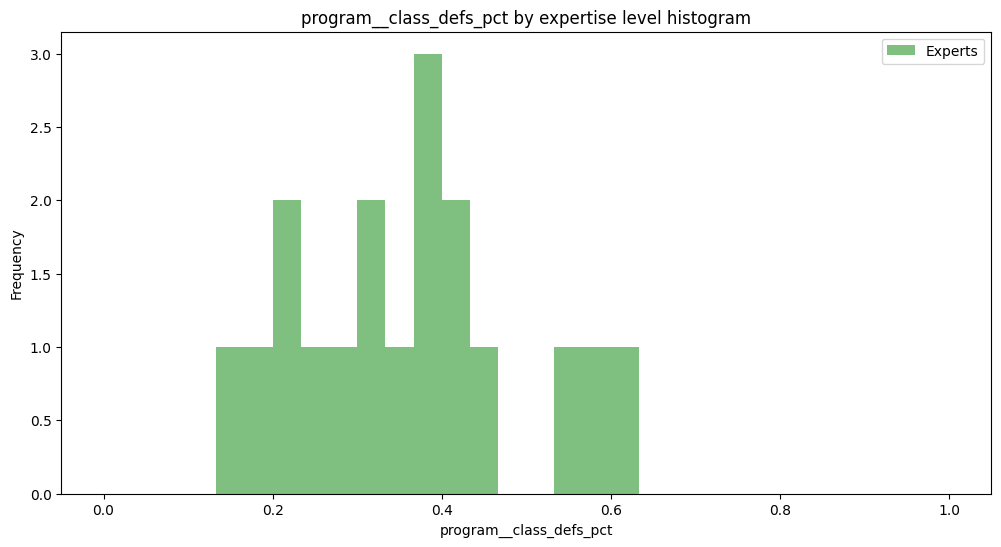

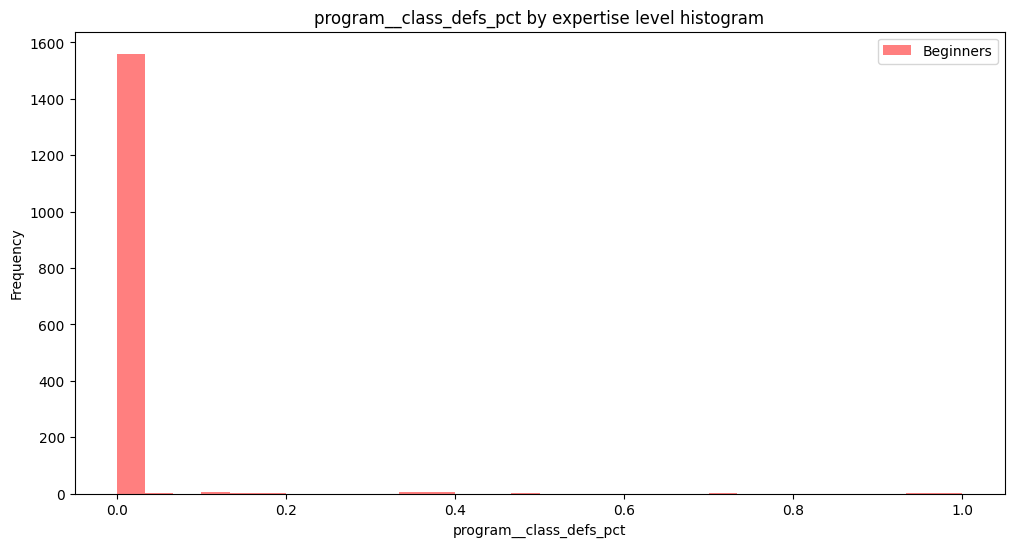

In [96]:
print_histogram(X, 'program__class_defs_pct', 'program__expertise_level', bins=30, include_all=True, include_experts=False, include_beginners=False)
print_histogram(X, 'program__class_defs_pct', 'program__expertise_level', bins=30, include_all=False, include_experts=True, include_beginners=False)
print_histogram(X, 'program__class_defs_pct', 'program__expertise_level', bins=30, include_all=False, include_experts=False, include_beginners=True)

In [97]:
print_outliers_for_df_column(X, 'program__class_defs_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9221833972889253
Rango valores atípicos extremos (Tukey): [0.0,0.0]
Rango valores atípicos leves (Tukey): [0.0,0.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.0,0.0]
-3.0IQR: 0 instancias tienen un valor para program__class_defs_pct inferior a 0.0 (Q1-3*IQR) para program__class_defs_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para program__class_defs_pct inferior a 0.0 (Q1-1.5*IQR) para program__class_defs_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 49 instancias tienen un valor para program__class_defs_pct superior a 0.0 (Q3+1.5*IQR) para program__class_defs_pct. Representando un 3.045% del total de instancias.
+3.0IQR: 49 instancias tienen un valor para program__class_defs_pct superior a 0.0 (Q3-3*IQR) para program__class_defs_pct. Representando un 3.045% del total de instancias.
L: 0 instancias tienen un valor para program__class_defs_pct inferior a 0.0

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 0 (Todos los umbrales son 0)

In [98]:
X[X['program__class_defs_pct'] > 0.0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,0.489796,0.469388,294.163269,12.224490,54.081635,0.373322,0.624973,0.001705,0.897959,4.936073,0.632653,0.367347
std,0.505076,0.504234,664.823975,37.963394,191.247757,0.264789,0.264567,0.004187,0.305839,4.329446,0.487078,0.487078
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.733333,0.000000,0.000000
25%,0.000000,0.000000,4.000000,0.000000,0.000000,0.179310,0.549844,0.000000,1.000000,2.333333,0.000000,0.000000
50%,0.000000,0.000000,6.000000,0.000000,0.000000,0.344754,0.644540,0.000000,1.000000,4.500000,1.000000,0.000000
75%,1.000000,1.000000,396.000000,4.000000,52.000000,0.449377,0.820690,0.000000,1.000000,5.776340,1.000000,1.000000
max,1.000000,1.000000,3294.000000,238.000000,1297.000000,1.000000,0.954545,0.019078,1.000000,23.000000,1.000000,1.000000


In [99]:
X[X['program__class_defs_pct'] == 1].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.00,3.0,3.0
mean,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.75,1.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
min,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.75,1.0,0.0
25%,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.75,1.0,0.0
50%,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.75,1.0,0.0
75%,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.75,1.0,0.0
max,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.75,1.0,0.0


### IMPORTANTE
Los tres resultados con class_defs_pct = 1 es el mismo trabajo en grupo. "Poker Huesca Hold'em". Esto se podría deber a una exagerada encapsulación o a un uso inadecuado del POO.

### Variable function_defs_pct (9/10)
Esta variable representa el porcentage de las definiciones de un programa que son funciones. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 100. Con una media de 65%.


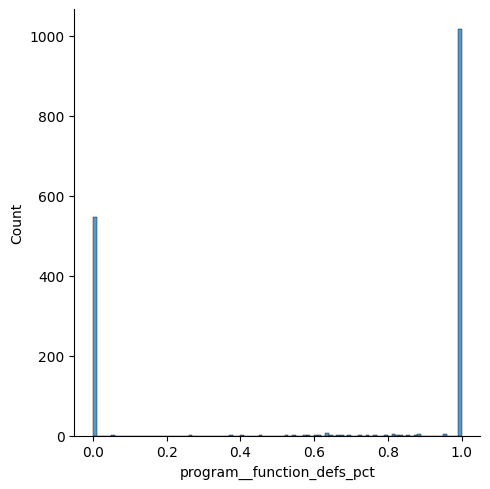

In [100]:
sns.displot(X['program__function_defs_pct'], bins=[i / 100 for i in range(0, 101)])

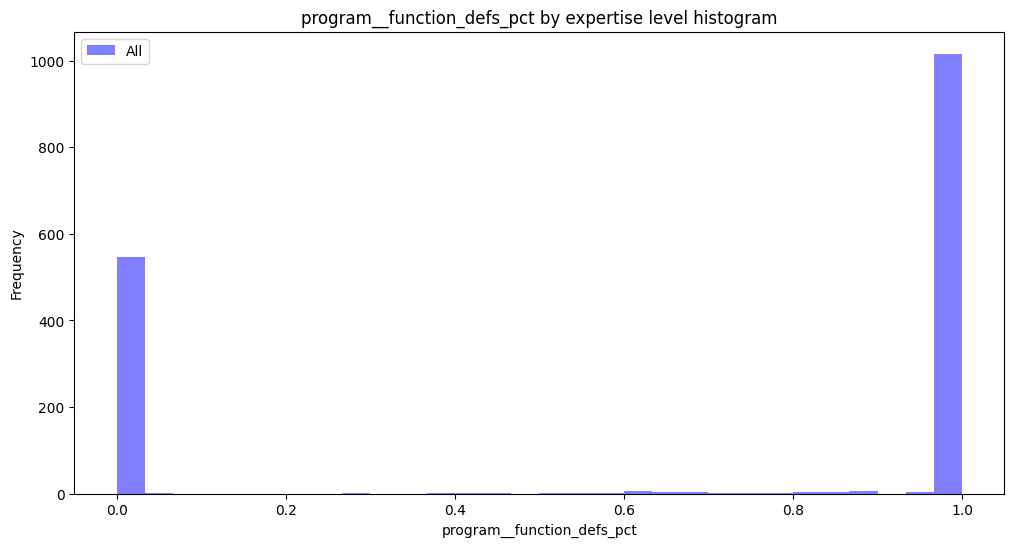

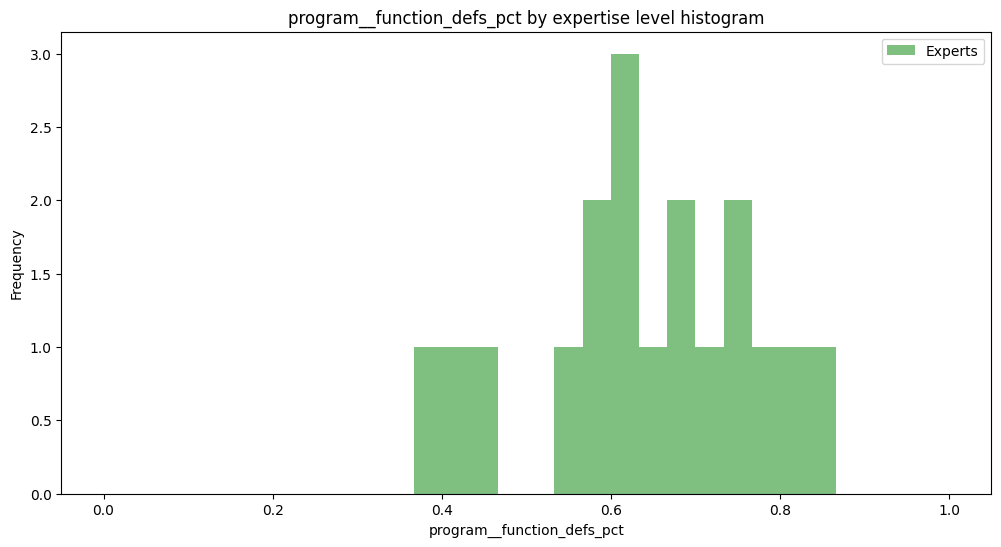

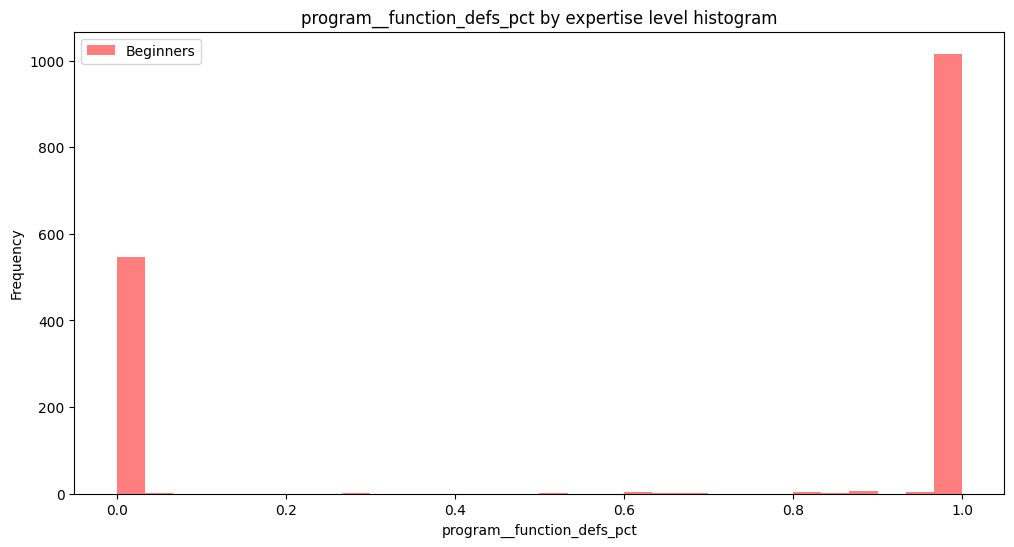

In [101]:
print_histogram(X, 'program__function_defs_pct', 'program__expertise_level', bins=30, include_all=True, include_beginners=False, include_experts=False)
print_histogram(X, 'program__function_defs_pct', 'program__expertise_level', bins=30, include_all=False, include_beginners=False, include_experts=True)
print_histogram(X, 'program__function_defs_pct', 'program__expertise_level', bins=30, include_all=False, include_beginners=True, include_experts=False)

In [102]:
print_outliers_for_df_column(X, 'program__function_defs_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: -0.3384833265327326
Rango valores atípicos extremos (Tukey): [-3.0,4.0]
Rango valores atípicos leves (Tukey): [-1.5,2.5]
Rango valores atípicos extremos (Fixed BoxPlot): [-5.808941766395405,1.4587607095781354]
-3.0IQR: 0 instancias tienen un valor para program__function_defs_pct inferior a -3.0 (Q1-3*IQR) para program__function_defs_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para program__function_defs_pct inferior a -1.5 (Q1-1.5*IQR) para program__function_defs_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 0 instancias tienen un valor para program__function_defs_pct superior a 2.5 (Q3+1.5*IQR) para program__function_defs_pct. Representando un 0.0% del total de instancias.
+3.0IQR: 0 instancias tienen un valor para program__function_defs_pct superior a 4.0 (Q3-3*IQR) para program__function_defs_pct. Representando un 0.0% del total de instancias.
L: 0 instancias tienen

### IMPORTANTE
Estos valores siguen un distribucion en forma de U (distribucion de Laplace). Con lo que los posibles valores outliers estan en el medio, no en los extremos. No se puede aplicar el metodo de tukey. En este momento, solo vamos a mostrar los valores que hay en el medio.

In [103]:
X[(X['program__function_defs_pct'] > 0.0) & (X['program__function_defs_pct'] < 1.0)].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,0.521739,0.500000,313.086945,13.021739,57.608696,0.332452,0.665732,0.001816,0.891304,5.209077,0.608696,0.391304
std,0.505047,0.505525,682.259460,39.072861,196.993332,0.216561,0.216620,0.004301,0.314696,4.330047,0.493435,0.493435
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.045455,0.052632,0.000000,0.000000,0.733333,0.000000,0.000000
25%,0.000000,0.000000,3.250000,0.000000,0.000000,0.166648,0.588648,0.000000,1.000000,2.816429,0.000000,0.000000
50%,1.000000,0.500000,23.500000,1.000000,1.000000,0.333333,0.666667,0.000000,1.000000,4.663352,1.000000,0.000000
75%,1.000000,1.000000,450.000000,4.000000,63.250000,0.411352,0.832619,0.000293,1.000000,5.782974,1.000000,1.000000
max,1.000000,1.000000,3294.000000,238.000000,1297.000000,0.947368,0.954545,0.019078,1.000000,23.000000,1.000000,1.000000


### Variable enum_defs_pct (10/10)
Esta variable representa el porcentage de las definiciones de un programa que son clases. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 100. Con una media de 0.0052%. Un máximo de 19%.

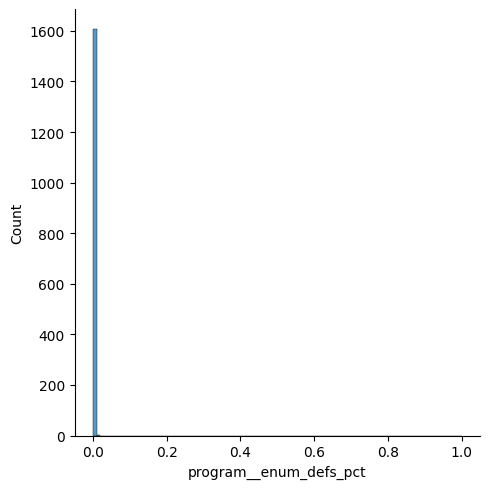

In [104]:
sns.displot(X['program__enum_defs_pct'], bins=[i / 100 for i in range(0, 101)])

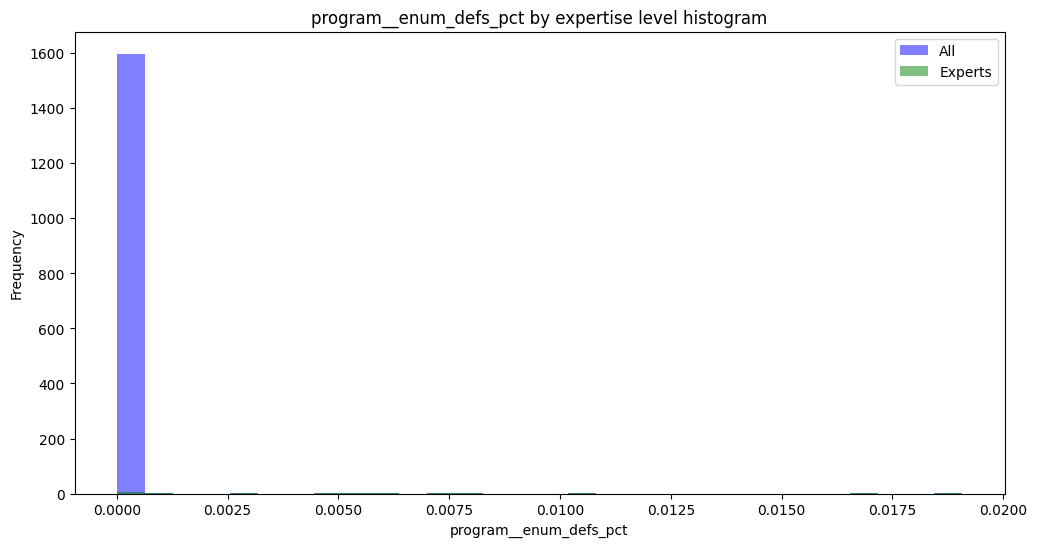

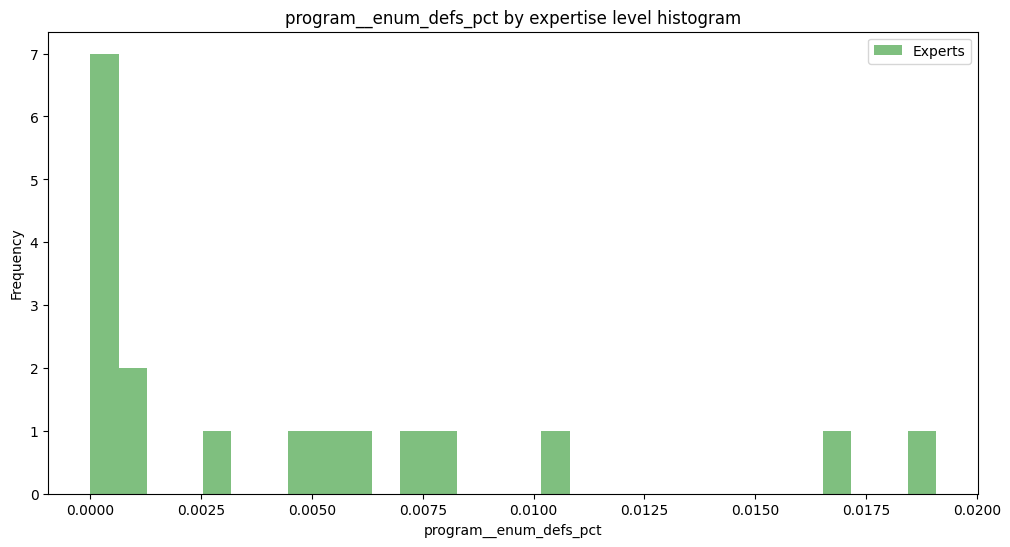

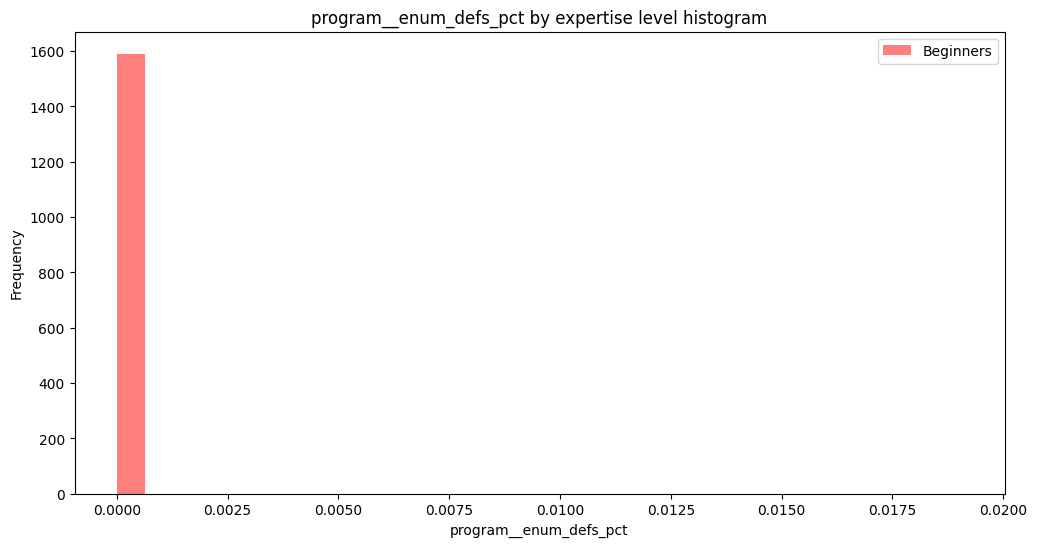

In [105]:
print_histogram(X, 'program__enum_defs_pct', 'program__expertise_level', bins=30, include_all=True, include_experts=True, include_beginners=False)
print_histogram(X, 'program__enum_defs_pct', 'program__expertise_level', bins=30, include_all=False, include_experts=True, include_beginners=False)
print_histogram(X, 'program__enum_defs_pct', 'program__expertise_level', bins=30, include_all=False, include_experts=False, include_beginners=True)

In [106]:
print_outliers_for_df_column(X, 'program__enum_defs_pct')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.9653851596665214
Rango valores atípicos extremos (Tukey): [0.0,0.0]
Rango valores atípicos leves (Tukey): [0.0,0.0]
Rango valores atípicos extremos (Fixed BoxPlot): [0.0,0.0]
-3.0IQR: 0 instancias tienen un valor para program__enum_defs_pct inferior a 0.0 (Q1-3*IQR) para program__enum_defs_pct. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para program__enum_defs_pct inferior a 0.0 (Q1-1.5*IQR) para program__enum_defs_pct. Representando un 0.0% del total de instancias.
+1.5IQR: 12 instancias tienen un valor para program__enum_defs_pct superior a 0.0 (Q3+1.5*IQR) para program__enum_defs_pct. Representando un 0.7458% del total de instancias.
+3.0IQR: 12 instancias tienen un valor para program__enum_defs_pct superior a 0.0 (Q3-3*IQR) para program__enum_defs_pct. Representando un 0.7458% del total de instancias.
L: 0 instancias tienen un valor para program__enum_defs_pct inferior a 0.0 para p

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 0 (Todos los umbrales son 0)

In [107]:
X[X['program__enum_defs_pct'] > 0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,12.0,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.0
mean,1.0,1.0,840.500000,47.000000,174.500000,0.339007,0.654032,0.006961,0.666667,4.344106,0.0,1.0
std,0.0,0.0,1162.297607,67.312027,368.791534,0.113283,0.113137,0.006050,0.492366,2.432481,0.0,0.0
min,1.0,1.0,118.000000,3.000000,5.000000,0.162427,0.408678,0.000391,0.000000,1.709030,0.0,1.0
25%,1.0,1.0,144.750000,6.750000,10.500000,0.269902,0.603234,0.002618,0.000000,2.919119,0.0,1.0
50%,1.0,1.0,370.500000,18.500000,37.000000,0.330762,0.661555,0.005803,1.000000,3.489617,0.0,1.0
75%,1.0,1.0,680.500000,53.000000,103.500000,0.385899,0.728417,0.008536,1.000000,5.526147,0.0,1.0
max,1.0,1.0,3294.000000,238.000000,1297.000000,0.585267,0.836595,0.019078,1.000000,9.957198,0.0,1.0


### IMPORTANTE
La mayoría de programas con un valor extremo de average_defs_per_module son de alumnos. Puede implicar un mal uso de la POO.

## Multivariate

Isolation forest algorithm

In [108]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012
isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.values)
mask = isof_prediction == -1
full_table.loc[X.index[mask]]

,program__program_id,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level
1605,6295774,True,True,3294,68,1297,0.368945,0.611977,0.019078,False,1.829994,EXPERT
1606,6983412,True,True,3278,238,382,0.248424,0.746025,0.005551,False,4.451495,EXPERT


### IMPORTANTE
Ambos outliers son los dos programas más grandes devueltos por la API de GitHub. ray y llama_index.

In [109]:
# Outliers
np.transpose(X[mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
program__has_sub_dirs_with_code,2.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
program__has_packages,2.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
program__number_of_modules,2.0,3286.000000,11.313708,3278.000000,3282.000000,3286.000000,3290.000000,3294.000000
program__number_of_sub_dirs_with_code,2.0,153.000000,120.208153,68.000000,110.500000,153.000000,195.500000,238.000000
program__number_of_packages,2.0,839.500000,647.002686,382.000000,610.750000,839.500000,1068.250000,1297.000000
program__class_defs_pct,2.0,0.308684,0.085221,0.248424,0.278554,0.308684,0.338815,0.368945
program__function_defs_pct,2.0,0.679001,0.094786,0.611977,0.645489,0.679001,0.712513,0.746025
program__enum_defs_pct,2.0,0.012314,0.009565,0.005551,0.008933,0.012314,0.015696,0.019078
program__has_code_root_package,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
program__average_defs_per_module,2.0,3.140744,1.853681,1.829994,2.485369,3.140744,3.796120,4.451495


In [110]:
# Non-Outliers
np.transpose(X[~mask].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,mean,std,min,25%,50%,75%,max
program__has_sub_dirs_with_code,1607.0,0.030492,0.171989,0.0,0.0,0.000000,0.000000,1.000000
program__has_packages,1607.0,0.013068,0.113601,0.0,0.0,0.000000,0.000000,1.000000
program__number_of_modules,1607.0,7.252022,48.573517,1.0,1.0,3.000000,3.000000,730.000000
program__number_of_sub_dirs_with_code,1607.0,0.204729,3.082676,0.0,0.0,0.000000,0.000000,99.000000
program__number_of_packages,1607.0,0.604231,6.612862,0.0,0.0,0.000000,0.000000,120.000000
program__class_defs_pct,1607.0,0.010999,0.078125,0.0,0.0,0.000000,0.000000,1.000000
program__function_defs_pct,1607.0,0.650445,0.471926,0.0,0.0,1.000000,1.000000,1.000000
program__enum_defs_pct,1607.0,0.000037,0.000605,0.0,0.0,0.000000,0.000000,0.017021
program__has_code_root_package,1607.0,0.998133,0.043180,0.0,1.0,1.000000,1.000000,1.000000
program__average_defs_per_module,1607.0,1.802416,2.951589,0.0,0.0,0.666667,2.142857,26.000000
